In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import xarray as xr
import matplotlib.colors as pltc
import geopandas
import datetime as dt
from scipy import stats
from sklearn import preprocessing
import s3fs
import matplotlib as mpl
import dataretrieval as nwis
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42

## Cubic feet to cubic meters conversion factor
cfs_2_cms = 0.0283168466

/opt/miniconda3/lib/python3.9/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


In [20]:
from pynhd import NLDI, WaterData, NHDPlusHR
import pynhd as nhd

In [66]:
nldi = NLDI()
gage = "13311000"
gageInfo = nwis.get_info(sites = gage)[0]
station = gageInfo['station_nm'][0]
tt = [gageInfo['dec_lat_va'][0],gageInfo['dec_long_va'][0]]
tt

[44.9057222, -115.3295]

In [67]:
nldi.comid_byloc(coords=tt)

TypeError: object of type 'numpy.float64' has no len()

In [9]:
#### Define Site
comid = 23551772
gage = '13311000'
station = nwis.get_info(sites = gage)[0]['station_nm'][0]
# station = "Scatter Creek Rochester, WA"
station

'EF OF SF SALMON RIVER AT STIBNITE, ID'

In [10]:
## Get spatial refence from modeled data sets
shp = geopandas.read_file("../data/VIC_UW/shapefiles/columbia_seg.shp")
shp = shp.loc[shp['POI_ID']==comid]
seg_ids = np.array(shp['seg_id'])
print(seg_ids)

if seg_ids.size == 0:
    print("No VIC or PRMS data")
else:
    ## Open modeled datasets and extract data at segment locations.
    VICdata = xr.open_mfdataset('../data/VIC_UW/vic_historical_first_route_all.nc',parallel=True)
    VICdata = VICdata.compute()
    VICdata = VICdata.where(VICdata['reachID']==seg_ids,drop=True)
    VICdata = VICdata[['reachID','IRFroutedRunoff']].to_dataframe()
    VICdata = VICdata.drop(['reachID'],axis=1)
    VICdata= VICdata.droplevel('seg')
    VICdata['time'] = pd.to_datetime(VICdata.index,)
    VICdata['time'] = VICdata['time'].dt.tz_localize(None)
    VICdata = VICdata.reset_index(drop=True)
    VICdata.columns = ["streamflow_VIC","time"]
    VICdata["streamflow_VIC"] = VICdata["streamflow_VIC"]*cfs_2_cms


    PRMSdata = xr.open_mfdataset('../data/VIC_UW/prms_historical_first_route_all.nc',parallel=True)
    PRMSdata = PRMSdata.compute()
    PRMSdata = PRMSdata.where(PRMSdata['reachID'].isin(seg_ids),drop=True)
    PRMSdata = PRMSdata[['reachID','IRFroutedRunoff']].to_dataframe()
    PRMSdata = PRMSdata.drop(['reachID'],axis=1)
    PRMSdata= PRMSdata.droplevel('seg')
    PRMSdata['time'] = pd.to_datetime(PRMSdata.index,)
    PRMSdata['time'] = PRMSdata['time'].dt.tz_localize(None)
    PRMSdata = PRMSdata.reset_index(drop=True)
    PRMSdata.columns = ["streamflow_PRMS","time"]
    PRMSdata["streamflow_PRMS"] = PRMSdata["streamflow_PRMS"]*cfs_2_cms

    ## Combine
    MergeData = pd.merge(VICdata,PRMSdata, on='time',how='inner')

[]
No VIC or PRMS data


In [11]:
### NWM
## Open NWM from NOAA AWS bucket
s3_path = 's3://noaa-nwm-retro-v2-zarr-pds' #nwm 2.0

# Connect to S3
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root=s3_path, s3=s3, check=False)

# load the dataset
ds = xr.open_zarr(store=store, consolidated=True)

## Get NWM 2.0 data
# slice all data using a specific reach identifier and time range
timerange = slice('1979-01-31', '2011-12-31')
dat = ds.sel(feature_id=comid,
             time=timerange).streamflow.persist() 

# This step takes a bit longer because it's actually returning the data
dat = dat.resample(time='1d').mean()

NWMdata = pd.DataFrame(dat.to_pandas())
NWMdata['time'] = pd.to_datetime(NWMdata.index)
NWMdata.columns = ["streamflow_NWM2d0","time"]
NWMdata = NWMdata.reset_index(drop=True)
NWMdata

if seg_ids.size == 0:
    MergeData = NWMdata
    MergeData["streamflow_VIC"] = 'NaN'
    MergeData["streamflow_PRMS"] = 'NaN'
else:
    ## Combine with above datasets
    MergeData = pd.merge(MergeData,NWMdata, on='time',how='inner')


In [12]:
## NWIS Data

if gage=='NaN':
    print("No NWIS data")
    # MergeData["streamflow_NWIS"] = np.zeros(len(MergeData))
    MergeData["streamflow_NWIS"] = 'NaN'
else:
    NWISdata = nwis.get_record(sites = gage,service='dv',
                           start = '1979-01-01', parameterCd = '00060')
    NWISdata = NWISdata.drop(['00060_Mean_cd','site_no'],axis=1)
    NWISdata.columns = ["streamflow_NWIS"]
    NWISdata['time'] = NWISdata.index
    NWISdata['time'] = pd.to_datetime(NWISdata['time']).dt.tz_localize(None)
    NWISdata["streamflow_NWIS"] = NWISdata["streamflow_NWIS"]*cfs_2_cms
    NWISdata = NWISdata.reset_index(drop=True)
    ## Combine all the data
    MergeData = pd.merge(MergeData,NWISdata, on='time',how='inner')

## Plot results

/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


TypeError: unsupported operand type(s) for -: 'str' and 'float'

<Figure size 720x432 with 0 Axes>

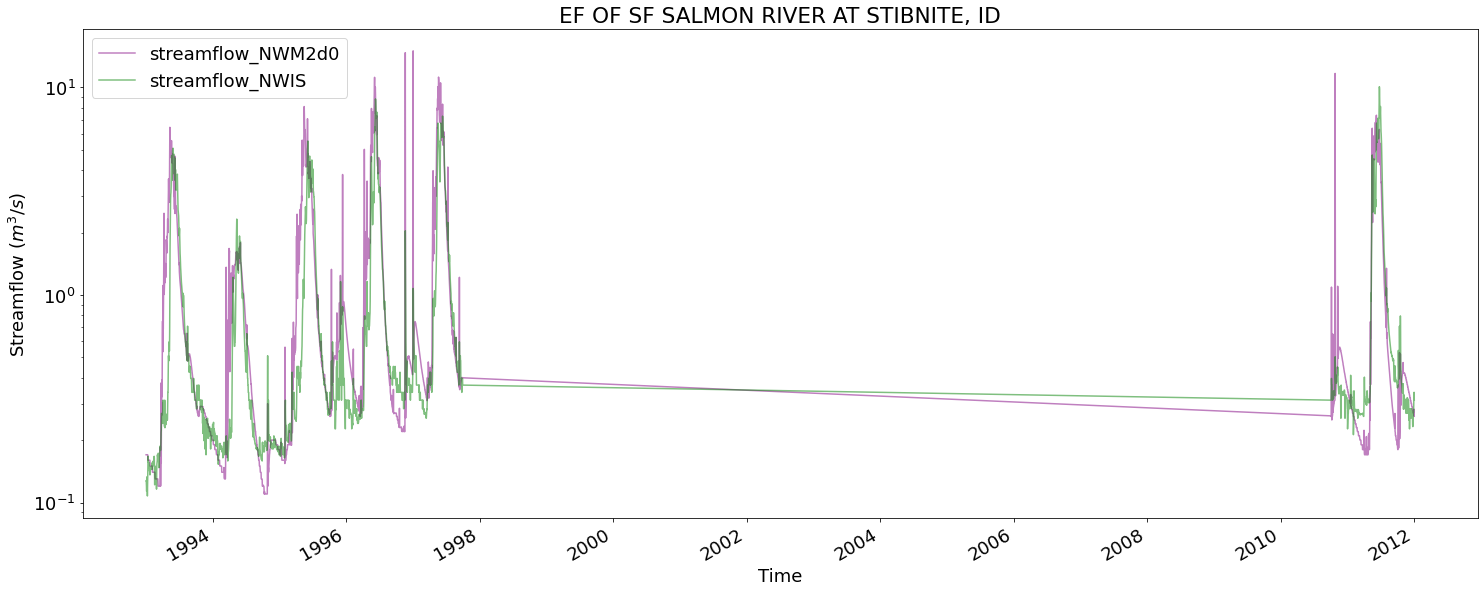

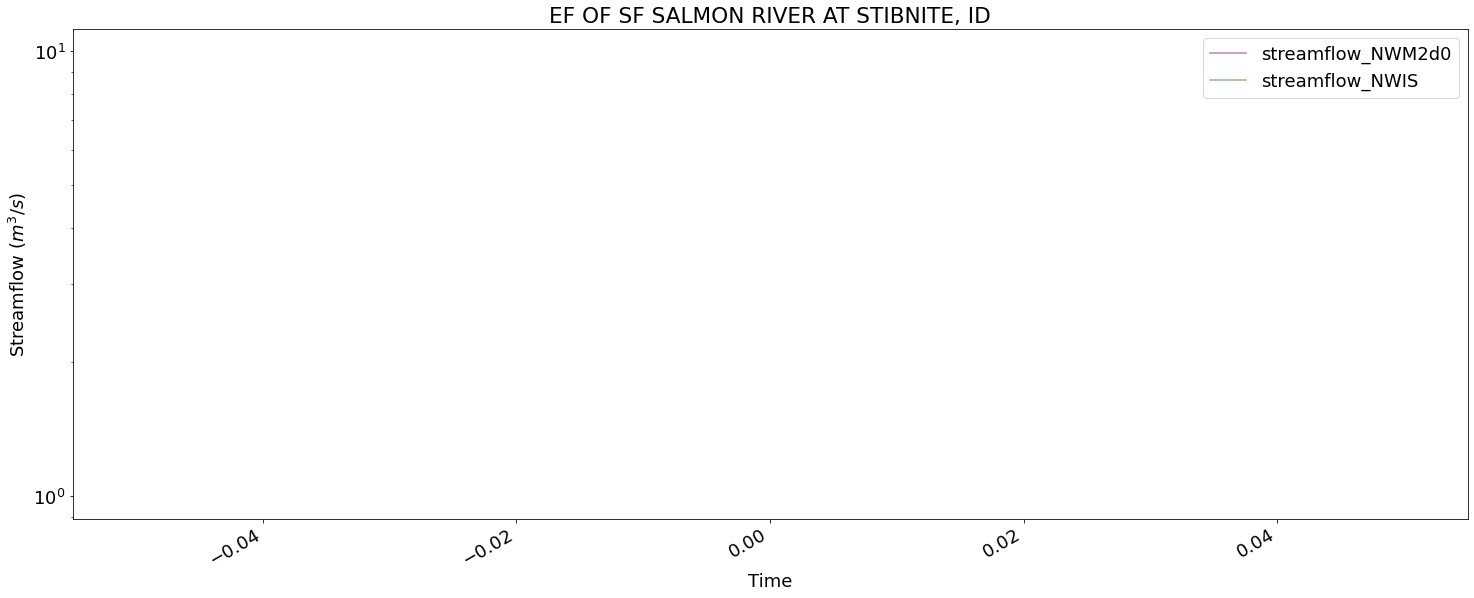

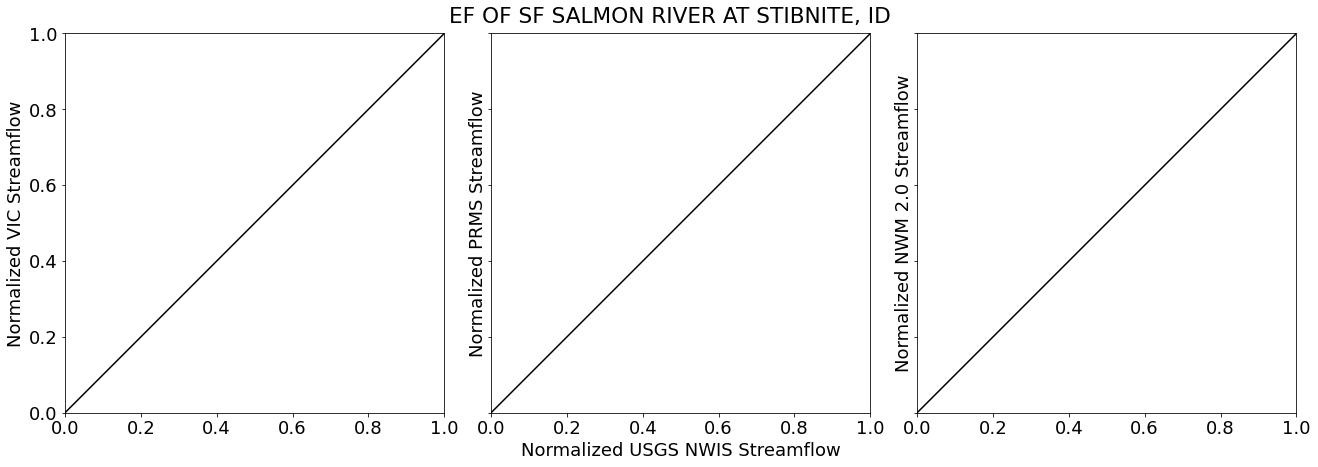

In [18]:
datMain = MergeData.copy()
######################
### Plot full streamflow record
######################
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,6))
# ax = datMain.plot(x = "time",y = ["streamflow_VIC",'streamflow_PRMS',"streamflow_NWM2d0",'streamflow_NWIS'],logy=True,figsize = (25,10),alpha=0.5,color = ['purple','green','crimson','grey'])
ax = datMain.plot(x = "time",logy=True,figsize = (25,10),alpha=0.5,color = ['purple','green','crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title(station)

# plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflow.pdf")
plt.savefig('../docs/pnwModeled/'+station+"_streamflow.png",dpi=300)

######################
## Plot streamflow from 2000 - 2004
######################

sub = datMain[ (datMain["time"] >= '2000-01-01') & (datMain["time"] <= '2004-12-31')]
# ax = sub.plot(x = "time",y = ["streamflow_VIC",'streamflow_PRMS',"streamflow_NWM2d0",'streamflow_NWIS'],logy=True,figsize = (25,10),alpha=0.5,color = ['purple','green','crimson','grey'])
ax = sub.plot(x = "time",logy=True,figsize = (25,10),alpha=0.5,color = ['purple','green','crimson','grey'])
# ax = datMain.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_title(station)
# ax.set_xlim(np.min(sub['time']),np.max(sub['time']))

# plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflowSubset.pdf")
plt.savefig('../docs/pnwModeled/'+station+"_streamflowSubset.png",dpi=300)

######################
## Make a normalized dataframe for plotting
######################

tt = datMain
tt.index = datMain['time']
tt =  tt.drop('time',axis=1)
tt = pd.DataFrame(preprocessing.minmax_scale(tt))
tt.index = datMain['time']
tt.columns = ["streamflow_VIC","streamflow_PRMS","streamflow_NWM2d0","streamflow_NWIS"]

# tt.to_csv('../data/pnwNP_modeledDataNormalized/'+str(shp['gage'][i])+"_normalized.csv")


######################
#### Plot 1 to 1
######################
if gage=='NaN':
    print("No NWIS data")
else:
    fig, axs = plt.subplots(1,3, sharey=True,figsize=(18,6),subplot_kw=dict(box_aspect=1))
    fig.suptitle(station)
    pt = (0, 0)
    plt.tight_layout(pad=0.4, w_pad=1, h_pad=0.5)
    axs[0].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_VIC"],alpha = 0.5,color = "purple",s=10)
    axs[1].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_PRMS"],alpha = 0.5,color = 'green',s=10)
    axs[2].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson',s=10)
    axs[0].axline(pt,slope=1, color='black')
    axs[1].axline(pt,slope=1, color='black')
    axs[2].axline(pt,slope=1, color='black')
    axs[0].set_ylabel('Normalized VIC Streamflow')
    axs[1].set_ylabel('Normalized PRMS Streamflow')
    axs[2].set_ylabel('Normalized NWM 2.0 Streamflow')
    axs[1].set_xlabel('Normalized USGS NWIS Streamflow')
    axs[0].set_ylim(0,1)
    axs[0].set_xlim(0,1)
    axs[1].set_ylim(0,1)
    axs[1].set_xlim(0,1)
    axs[2].set_ylim(0,1)
    axs[2].set_xlim(0,1)
    # plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_1to1.pdf",bbox_inches='tight')
    plt.savefig('../docs/pnwModeled/'+station+"_1to1.png",dpi=300,bbox_inches='tight')


    ######################
    #### Difference Boxplots
    ######################

    modDiff = datMain
    modDiff.index = datMain['time']
    modDiff =  modDiff.drop('time',axis=1)
    modDiff =  modDiff.sub(modDiff['streamflow_NWIS'], axis=0)
    modDiff = modDiff.drop('streamflow_NWIS',axis=1)


    plt.figure(figsize=(8,8))
    ax = sns.boxplot(data=modDiff,showfliers = False,palette=['purple', 'green','crimson'])
    ax.set_ylabel('Streamflow $(m^3/s)$')
    ax.set_xlabel('Simulation')
    ax.set_title(station + " ("+gage+")")
    ax.set_xticklabels(['VIC','PRMS','NWM2.0'])

    plt.savefig('../docs/pnwModeled/'+station+"_DiffBoxplots.png",dpi=300,bbox_inches='tight')

######################
#### Boxplots
######################

plt.figure(figsize=(8,8))
ax = sns.boxplot(data=datMain,showfliers = False,palette=['purple', 'green','crimson'])
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_xlabel('Simulation')
if gage=='NaN':
    ax.set_xticklabels(['VIC','PRMS','NWM2.0'])
    ax.set_title(station)
else:
    ax.set_xticklabels(['VIC','PRMS','NWM2.0','USGS NWIS'])
    ax.set_title(station + " ("+gage+")")

plt.savefig('../docs/pnwModeled/'+station+"_boxplots.png",dpi=300,bbox_inches='tight')

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (4).

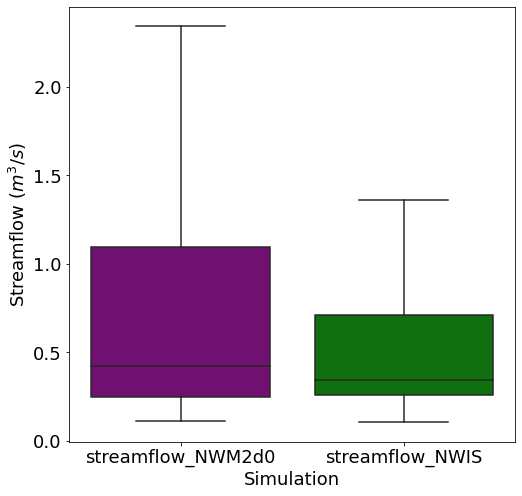

In [19]:
plt.figure(figsize=(8,8))
ax = sns.boxplot(data=datMain,showfliers = False,palette=['purple', 'green','crimson'])
ax.set_ylabel('Streamflow $(m^3/s)$')
ax.set_xlabel('Simulation')
if gage=='NaN':
    ax.set_xticklabels(['VIC','PRMS','NWM2.0'])
    ax.set_title(station)
else:
    ax.set_xticklabels(['VIC','PRMS','NWM2.0','USGS NWIS'])
    ax.set_title(station + " ("+gage+")")